## NAME: Souri Rishik Volety
## Reg No: 230968004

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import os
from datetime import datetime

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
GPU Available: []


In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = (X_train.astype('float32') - 127.5) / 127.5

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

print(f"Training data shape: {X_train.shape}")
print(f"Value range: [{X_train.min()}, {X_train.max()}]")

Training data shape: (60000, 28, 28, 1)
Value range: [-1.0, 1.0]


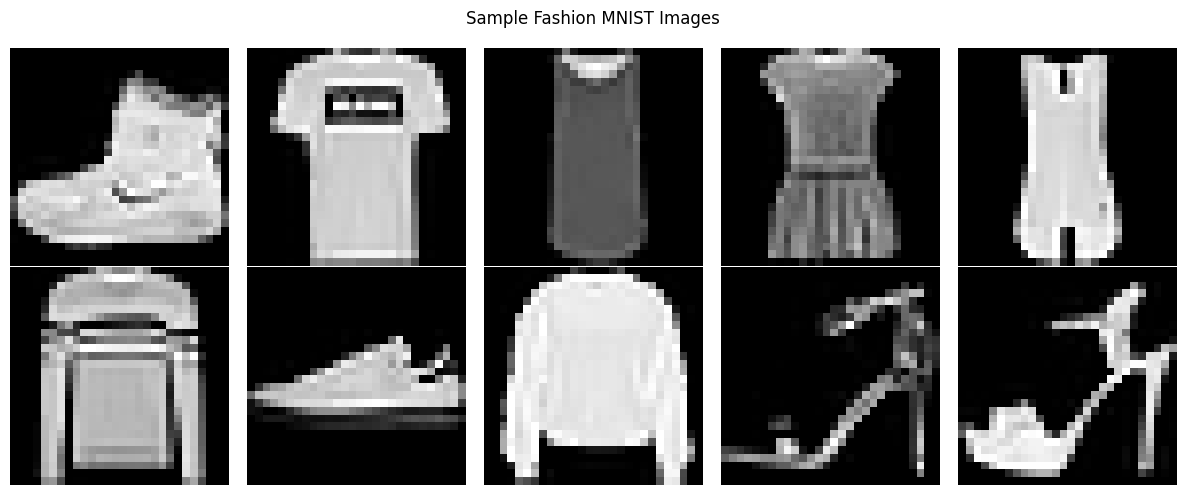

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.suptitle('Sample Fashion MNIST Images')
plt.tight_layout()
plt.show()

In [7]:
def build_generator(latent_dim):
    model = Sequential(name='Generator')

    model.add(Dense(7 * 7 * 256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(1, (5, 5), activation='tanh', padding='same'))
    
    return model

generator_test = build_generator(latent_dim=50)
print(generator_test.summary())

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             639744    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       819328    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 14, 14, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0 

2025-10-16 09:03:57.444619: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
def build_discriminator(img_shape=(28, 28, 1)):
    model = Sequential(name='Discriminator')

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                     input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

discriminator_test = build_discriminator()
print(discriminator_test.summary())

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)            

In [9]:
def build_gan(generator, discriminator):
    discriminator.trainable = False

    model = Sequential(name='GAN')
    model.add(generator)
    model.add(discriminator)
    
    return model

In [10]:
def train_gan(epochs, batch_size, latent_dim, save_interval=10):

    generator = build_generator(latent_dim)
    discriminator = build_discriminator()
    discriminator.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
        metrics=['accuracy']
    )

    gan = build_gan(generator, discriminator)
    gan.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
    )

    history = {
        'd_loss': [],
        'd_acc': [],
        'g_loss': [],
        'epochs': []
    }

    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    print(f"\nTraining GAN: Epochs={epochs}, Latent Dim={latent_dim}")
    print("="*60)
    
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real_labels)

        if epoch % 10 == 0:
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[1])
            history['g_loss'].append(g_loss)
            history['epochs'].append(epoch)

        if epoch % save_interval == 0:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss[0]:.4f}, "
                  f"D Acc: {d_loss[1]*100:.2f}% | G Loss: {g_loss:.4f}")
    
    print("="*60)
    print("Training completed!")
    
    return generator, discriminator, history

In [11]:
def generate_and_save_images(generator, latent_dim, n_samples=25, 
                            title="Generated Images", save=False, 
                            filename="generated_images.png"):

    noise = np.random.normal(0, 1, (n_samples, latent_dim))

    generated_images = generator.predict(noise, verbose=0)

    generated_images = 0.5 * generated_images + 0.5

    grid_size = int(np.sqrt(n_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    if save:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"Saved: {filename}")
    
    plt.show()
    
    return generated_images

In [12]:
def plot_training_history(history, title="Training History"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history['epochs'], history['d_loss'], label='Discriminator Loss', 
             marker='o', linewidth=2)
    ax1.plot(history['epochs'], history['g_loss'], label='Generator Loss', 
             marker='s', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('GAN Training Losses', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(history['epochs'], history['d_acc'], label='Discriminator Accuracy', 
             marker='o', linewidth=2, color='green')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Discriminator Accuracy', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [13]:
def run_all_experiments(epoch_list, latent_dim_list, batch_size=128, save_interval=10):
    results = {
        'generators': {},
        'discriminators': {},
        'histories': {},
        'images': {}
    }
    
    experiment_num = 1
    
    for epochs in epoch_list:
        for latent_dim in latent_dim_list:
            print("\n" + "="*70)
            print(f"EXPERIMENT {experiment_num}: Epochs={epochs}, Latent Dim={latent_dim}")
            print("="*70)

            generator, discriminator, history = train_gan(
                epochs=epochs,
                batch_size=batch_size,
                latent_dim=latent_dim,
                save_interval=save_interval
            )

            plot_training_history(
                history, 
                f"Experiment {experiment_num}: Epochs={epochs}, Latent Dim={latent_dim}"
            )

            filename = f"exp{experiment_num}_{epochs}epochs_{latent_dim}dim.png"
            generated_imgs = generate_and_save_images(
                generator,
                latent_dim=latent_dim,
                title=f"Experiment {experiment_num}: Generated Images ({epochs} epochs, latent_dim={latent_dim})",
                save=True,
                filename=filename
            )

            exp_key = f"exp{experiment_num}_{epochs}e_{latent_dim}d"
            results['generators'][exp_key] = generator
            results['discriminators'][exp_key] = discriminator
            results['histories'][exp_key] = history
            results['images'][exp_key] = generated_imgs
            
            print(f"\nExperiment {experiment_num} completed!")
            experiment_num += 1
    
    return results

Starting all experiments...
Total experiments: 9

EXPERIMENT 1: Epochs=100, Latent Dim=20

Training GAN: Epochs=100, Latent Dim=20
Epoch 0/100 | D Loss: 0.7109, D Acc: 14.06% | G Loss: 0.6651
Epoch 10/100 | D Loss: 0.4042, D Acc: 50.00% | G Loss: 0.0668
Epoch 20/100 | D Loss: 0.3451, D Acc: 100.00% | G Loss: 0.1798
Epoch 30/100 | D Loss: 0.4223, D Acc: 50.00% | G Loss: 0.0185
Epoch 40/100 | D Loss: 0.3150, D Acc: 98.83% | G Loss: 0.0889
Epoch 50/100 | D Loss: 0.1738, D Acc: 100.00% | G Loss: 0.0229
Epoch 60/100 | D Loss: 0.1316, D Acc: 99.22% | G Loss: 0.0143
Epoch 70/100 | D Loss: 0.0587, D Acc: 99.22% | G Loss: 0.0221
Epoch 80/100 | D Loss: 0.0356, D Acc: 100.00% | G Loss: 0.0344
Epoch 90/100 | D Loss: 0.0357, D Acc: 100.00% | G Loss: 0.0200
Training completed!


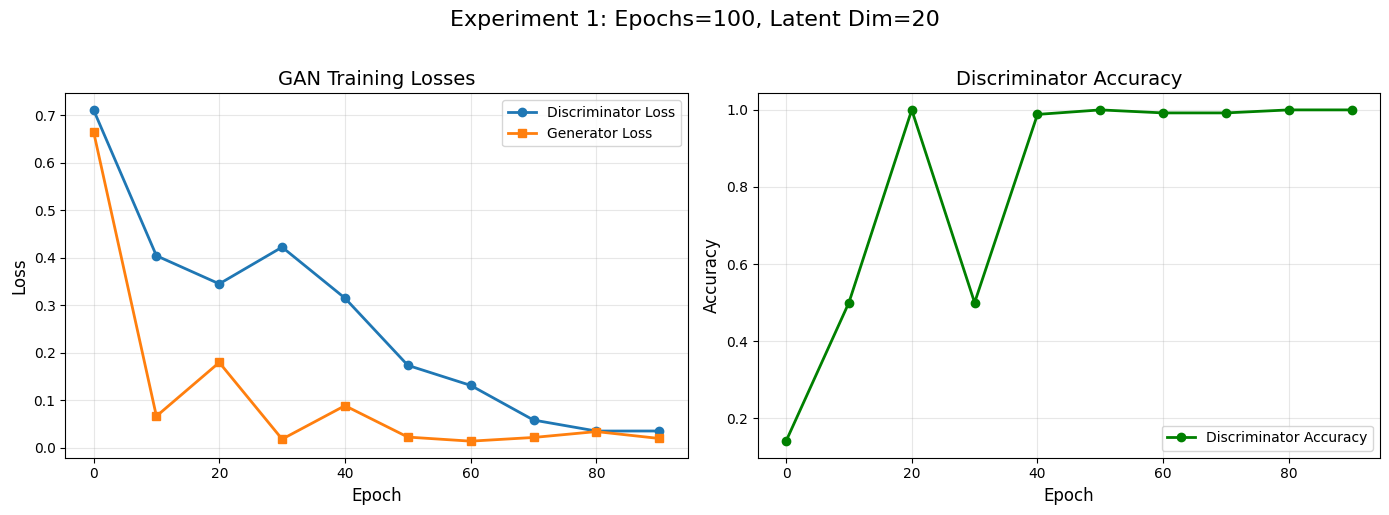

Saved: exp1_100epochs_20dim.png


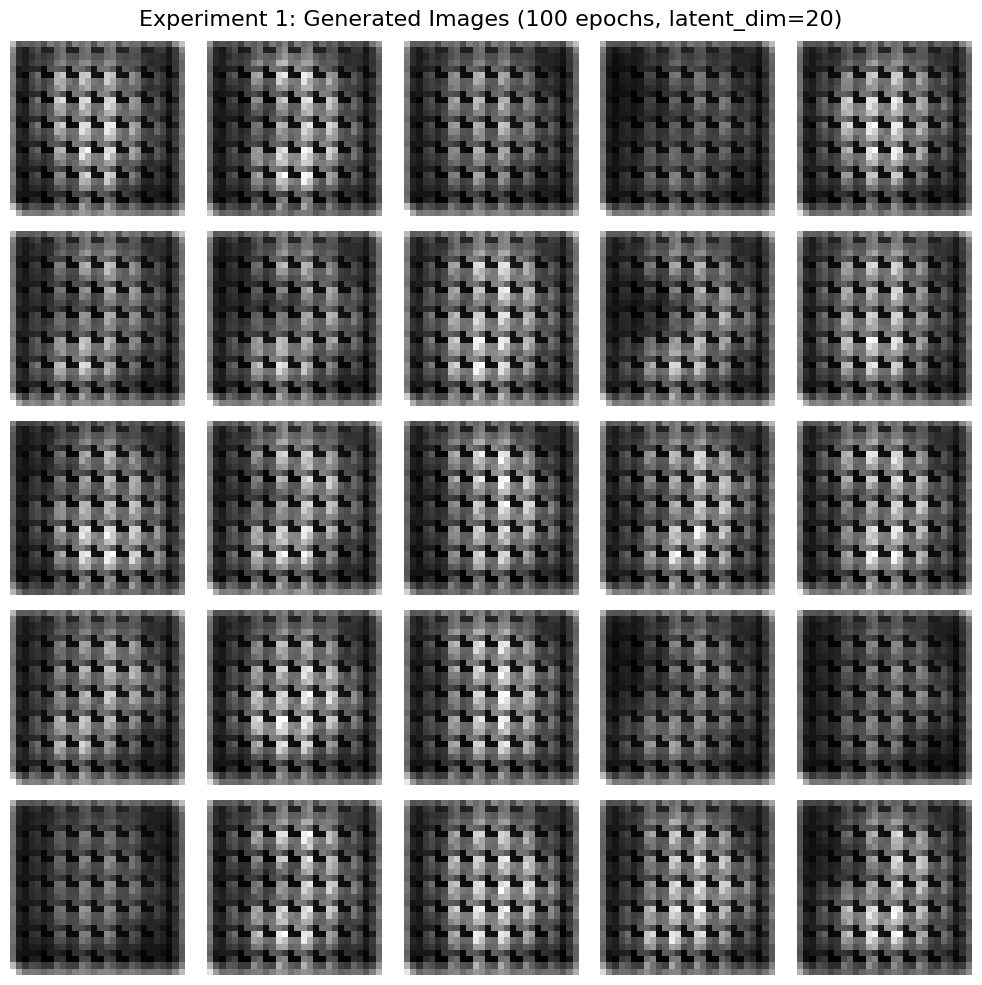


Experiment 1 completed!

EXPERIMENT 2: Epochs=100, Latent Dim=50

Training GAN: Epochs=100, Latent Dim=50
Epoch 0/100 | D Loss: 0.6811, D Acc: 38.28% | G Loss: 0.6246
Epoch 10/100 | D Loss: 0.3973, D Acc: 50.00% | G Loss: 0.1020
Epoch 20/100 | D Loss: 0.3887, D Acc: 50.00% | G Loss: 0.0380
Epoch 30/100 | D Loss: 0.3028, D Acc: 100.00% | G Loss: 0.0586
Epoch 40/100 | D Loss: 0.2431, D Acc: 100.00% | G Loss: 0.0138
Epoch 50/100 | D Loss: 0.1140, D Acc: 100.00% | G Loss: 0.0797
Epoch 60/100 | D Loss: 0.0691, D Acc: 100.00% | G Loss: 0.0076
Epoch 70/100 | D Loss: 0.0513, D Acc: 99.61% | G Loss: 0.0037
Epoch 80/100 | D Loss: 0.0483, D Acc: 98.83% | G Loss: 0.0025
Epoch 90/100 | D Loss: 0.0714, D Acc: 98.44% | G Loss: 0.0014
Training completed!


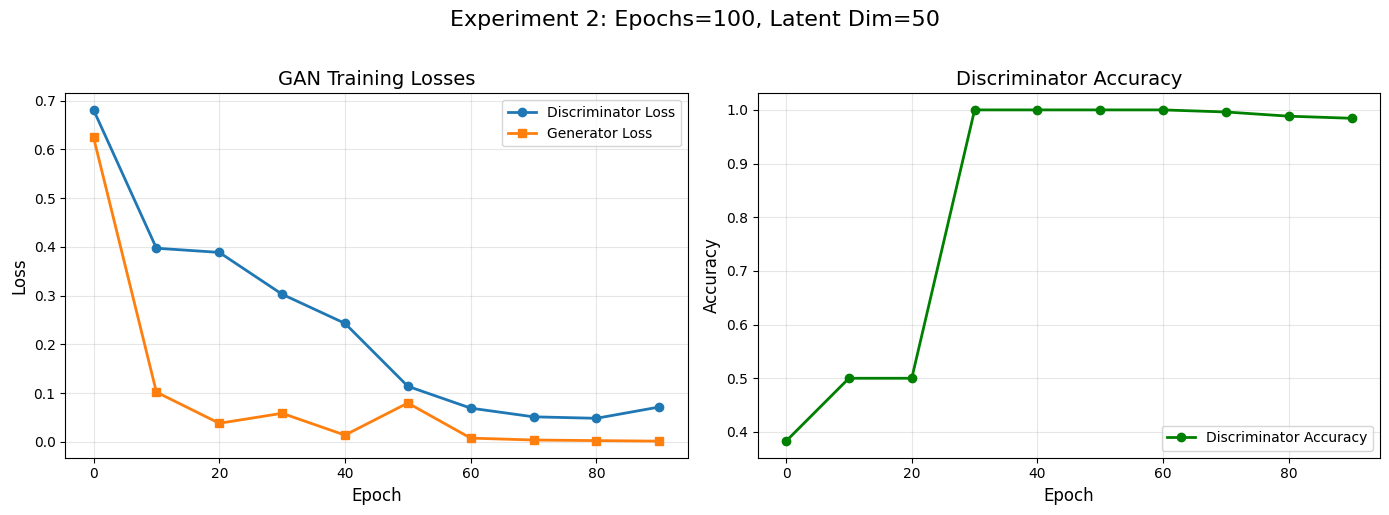

Saved: exp2_100epochs_50dim.png


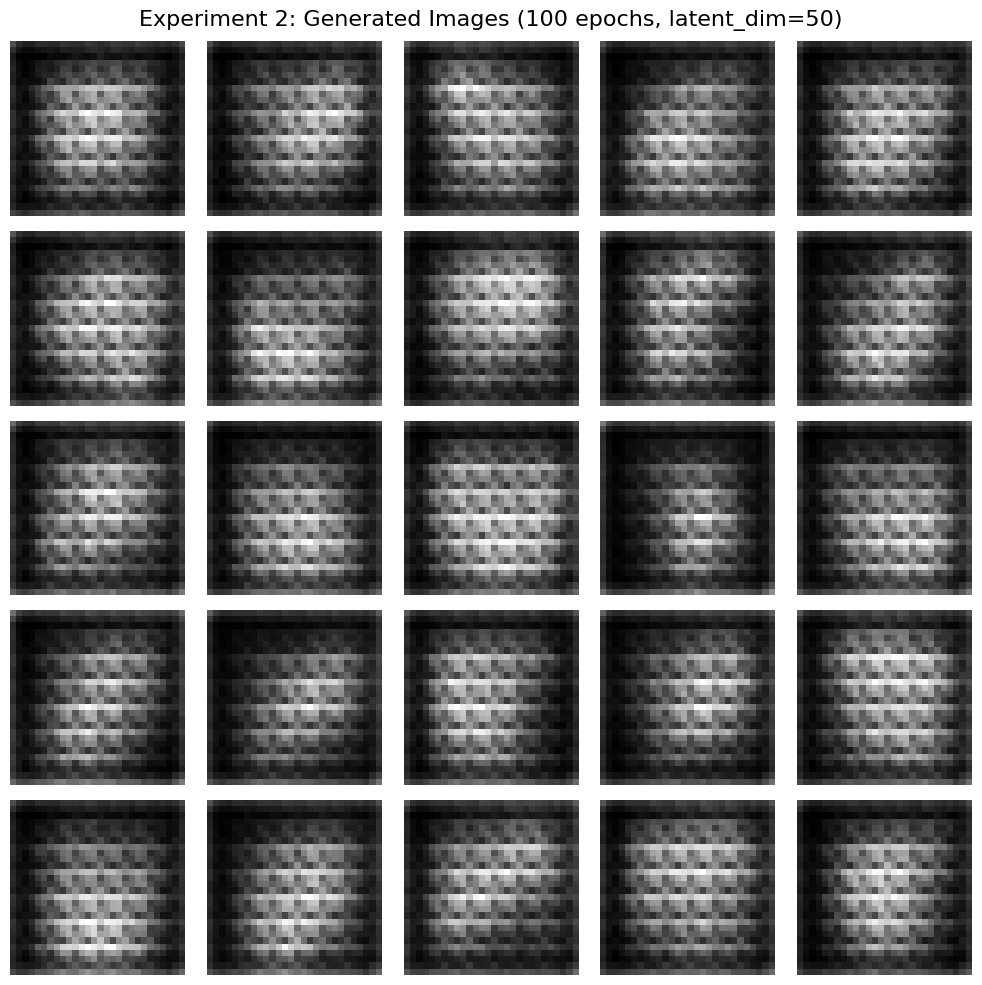


Experiment 2 completed!

EXPERIMENT 3: Epochs=100, Latent Dim=100

Training GAN: Epochs=100, Latent Dim=100
Epoch 0/100 | D Loss: 0.6908, D Acc: 30.47% | G Loss: 0.6540
Epoch 10/100 | D Loss: 0.3979, D Acc: 50.00% | G Loss: 0.1142
Epoch 20/100 | D Loss: 0.3288, D Acc: 100.00% | G Loss: 0.2520
Epoch 30/100 | D Loss: 0.2935, D Acc: 100.00% | G Loss: 0.6535
Epoch 40/100 | D Loss: 0.4515, D Acc: 54.30% | G Loss: 0.4965
Epoch 50/100 | D Loss: 0.2262, D Acc: 100.00% | G Loss: 0.5163
Epoch 60/100 | D Loss: 0.3976, D Acc: 88.28% | G Loss: 3.7177
Epoch 70/100 | D Loss: 0.2366, D Acc: 91.41% | G Loss: 2.2803
Epoch 80/100 | D Loss: 1.7667, D Acc: 37.89% | G Loss: 1.0774
Epoch 90/100 | D Loss: 0.4626, D Acc: 79.69% | G Loss: 0.2722
Training completed!


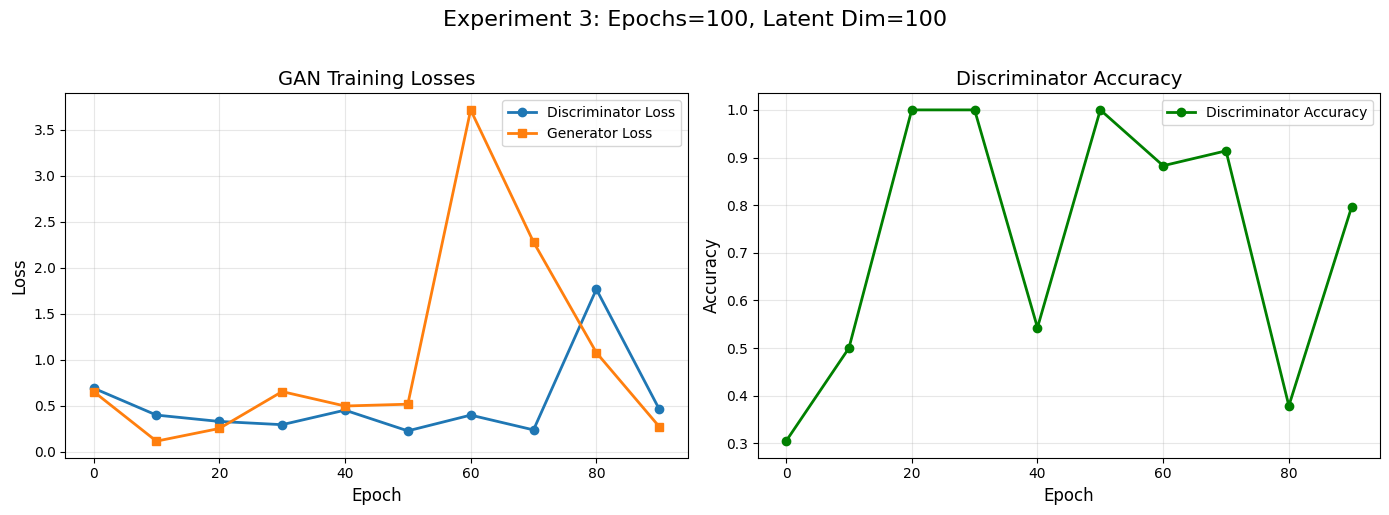

Saved: exp3_100epochs_100dim.png


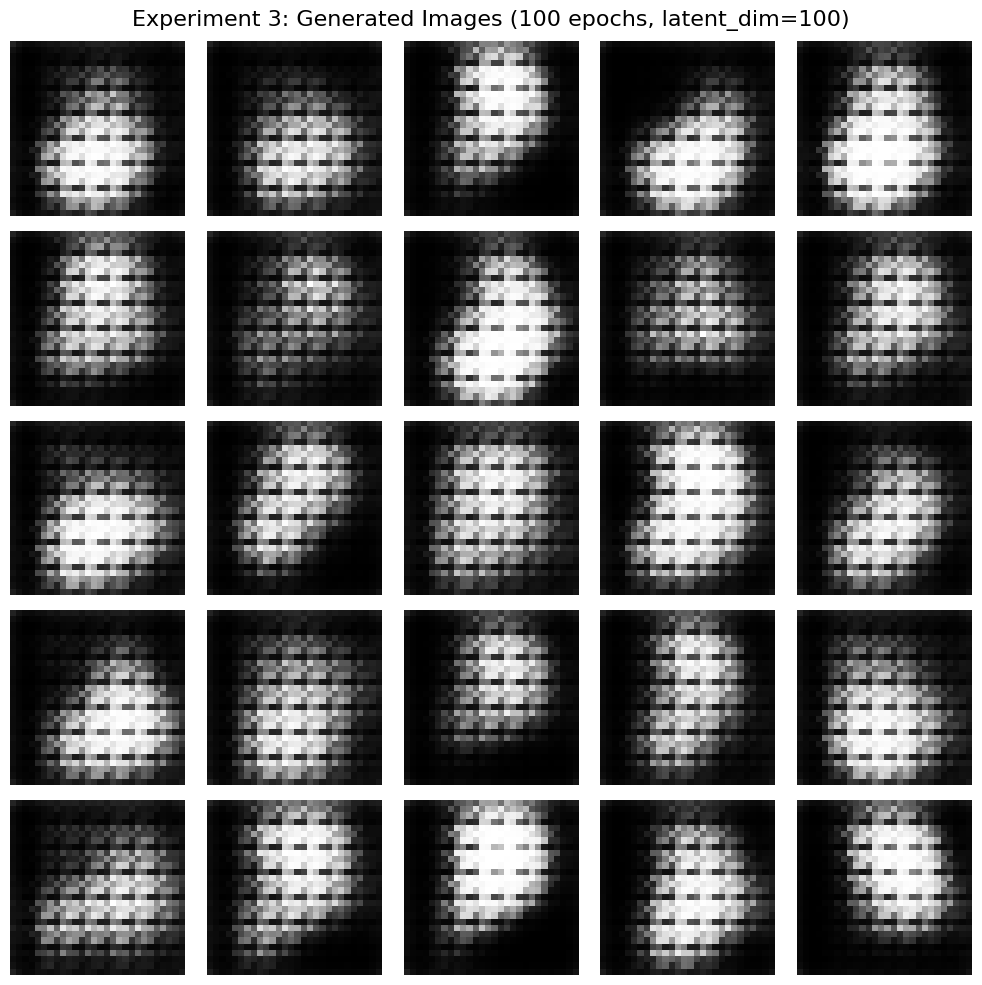


Experiment 3 completed!

EXPERIMENT 4: Epochs=150, Latent Dim=20

Training GAN: Epochs=150, Latent Dim=20
Epoch 0/150 | D Loss: 0.6867, D Acc: 30.47% | G Loss: 0.6356
Epoch 10/150 | D Loss: 0.3884, D Acc: 50.00% | G Loss: 0.0569
Epoch 20/150 | D Loss: 0.3463, D Acc: 100.00% | G Loss: 0.0667
Epoch 30/150 | D Loss: 0.3167, D Acc: 100.00% | G Loss: 0.0119
Epoch 40/150 | D Loss: 0.1402, D Acc: 100.00% | G Loss: 0.0084
Epoch 50/150 | D Loss: 0.0540, D Acc: 100.00% | G Loss: 0.0016
Epoch 60/150 | D Loss: 0.0250, D Acc: 100.00% | G Loss: 0.0046
Epoch 70/150 | D Loss: 0.0168, D Acc: 100.00% | G Loss: 0.0005
Epoch 80/150 | D Loss: 0.0273, D Acc: 100.00% | G Loss: 0.0004
Epoch 90/150 | D Loss: 0.0248, D Acc: 100.00% | G Loss: 0.0005
Epoch 100/150 | D Loss: 0.0316, D Acc: 99.22% | G Loss: 0.0004
Epoch 110/150 | D Loss: 0.0082, D Acc: 100.00% | G Loss: 0.0005
Epoch 120/150 | D Loss: 0.0041, D Acc: 100.00% | G Loss: 0.0002
Epoch 130/150 | D Loss: 0.0067, D Acc: 100.00% | G Loss: 0.0002
Epoch 140/1

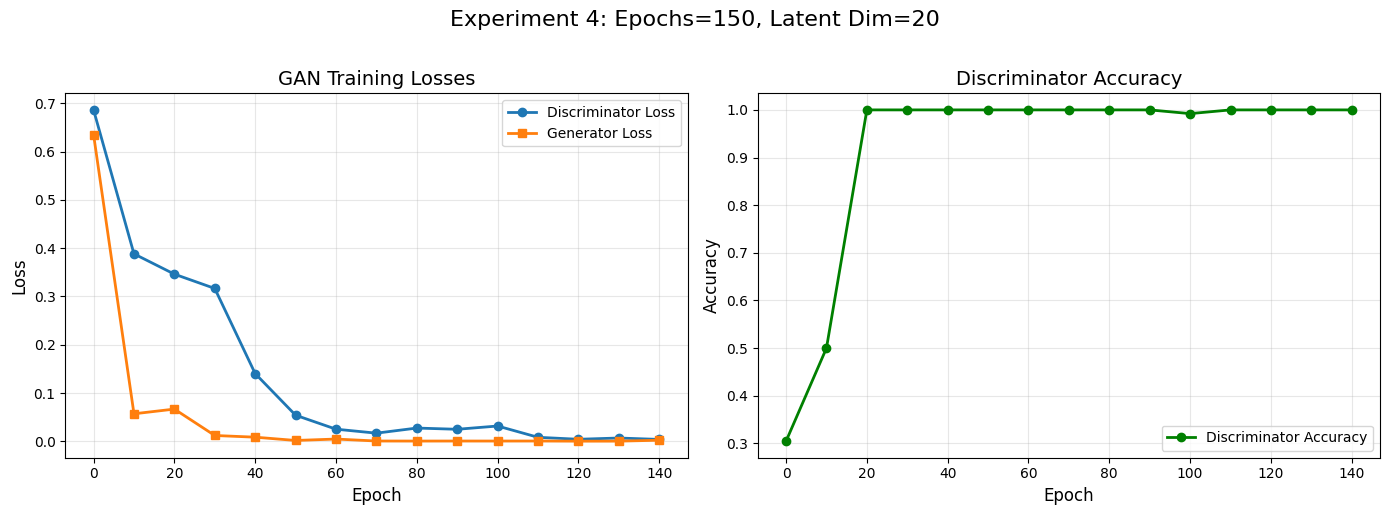

Saved: exp4_150epochs_20dim.png


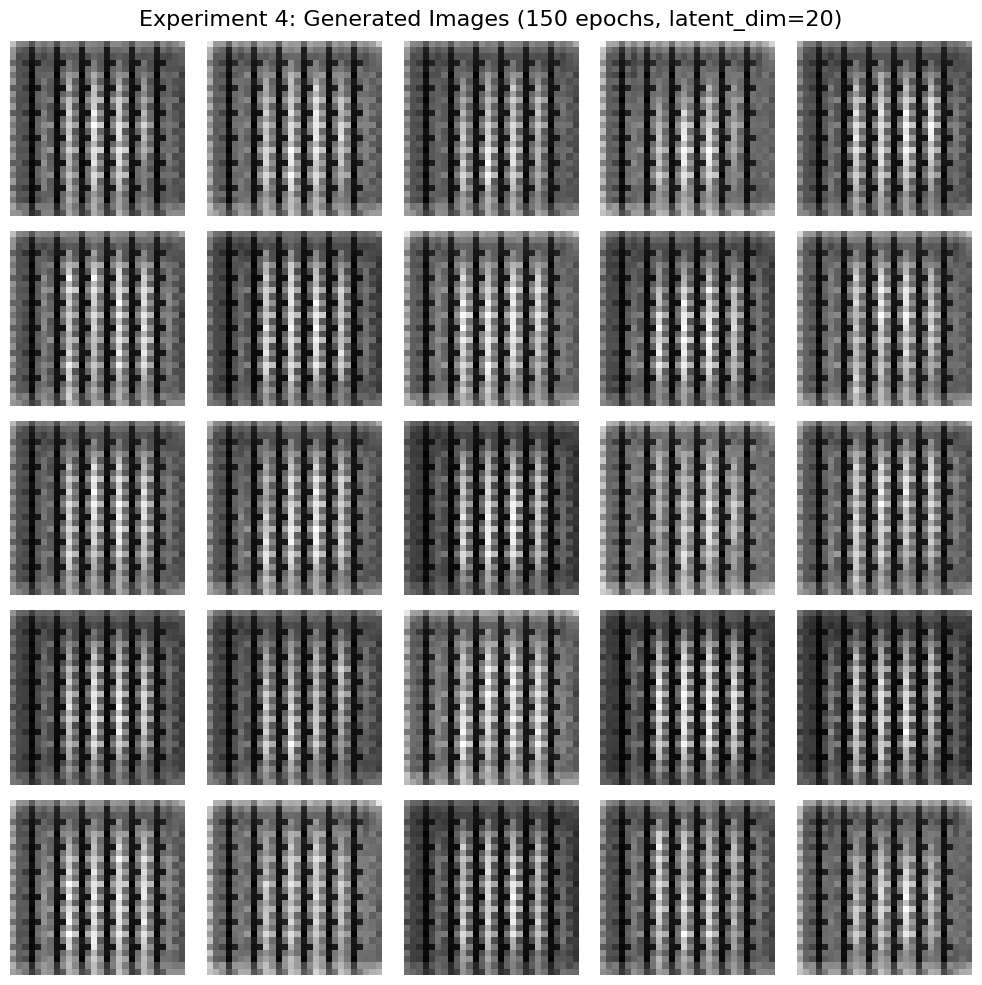


Experiment 4 completed!

EXPERIMENT 5: Epochs=150, Latent Dim=50

Training GAN: Epochs=150, Latent Dim=50
Epoch 0/150 | D Loss: 0.6994, D Acc: 28.91% | G Loss: 0.6737
Epoch 10/150 | D Loss: 0.3971, D Acc: 50.00% | G Loss: 0.0635
Epoch 20/150 | D Loss: 0.3626, D Acc: 69.92% | G Loss: 0.1981
Epoch 30/150 | D Loss: 0.3644, D Acc: 80.86% | G Loss: 0.0805
Epoch 40/150 | D Loss: 0.3001, D Acc: 100.00% | G Loss: 0.4279
Epoch 50/150 | D Loss: 0.2988, D Acc: 97.66% | G Loss: 0.1666
Epoch 60/150 | D Loss: 0.3026, D Acc: 95.70% | G Loss: 0.4012
Epoch 70/150 | D Loss: 0.6413, D Acc: 57.81% | G Loss: 0.3992
Epoch 80/150 | D Loss: 0.4895, D Acc: 79.30% | G Loss: 0.5707
Epoch 90/150 | D Loss: 0.5862, D Acc: 70.70% | G Loss: 0.6575
Epoch 100/150 | D Loss: 0.5477, D Acc: 74.61% | G Loss: 0.5485
Epoch 110/150 | D Loss: 0.6522, D Acc: 68.75% | G Loss: 0.1905
Epoch 120/150 | D Loss: 0.4614, D Acc: 80.86% | G Loss: 0.0496
Epoch 130/150 | D Loss: 0.3907, D Acc: 84.38% | G Loss: 0.0165
Epoch 140/150 | D Los

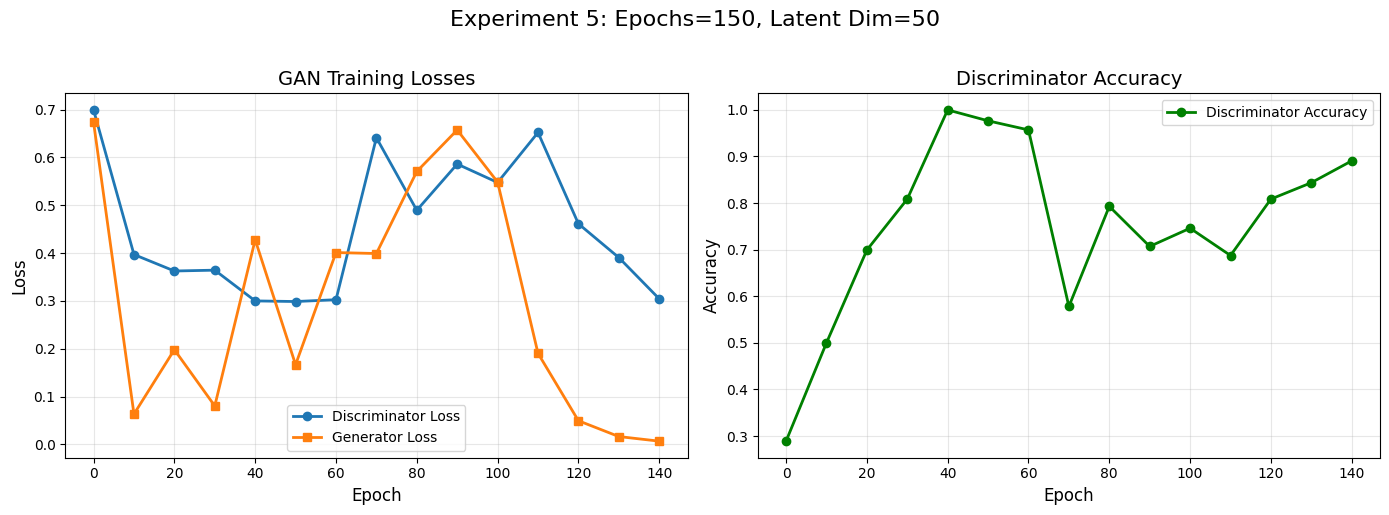

Saved: exp5_150epochs_50dim.png


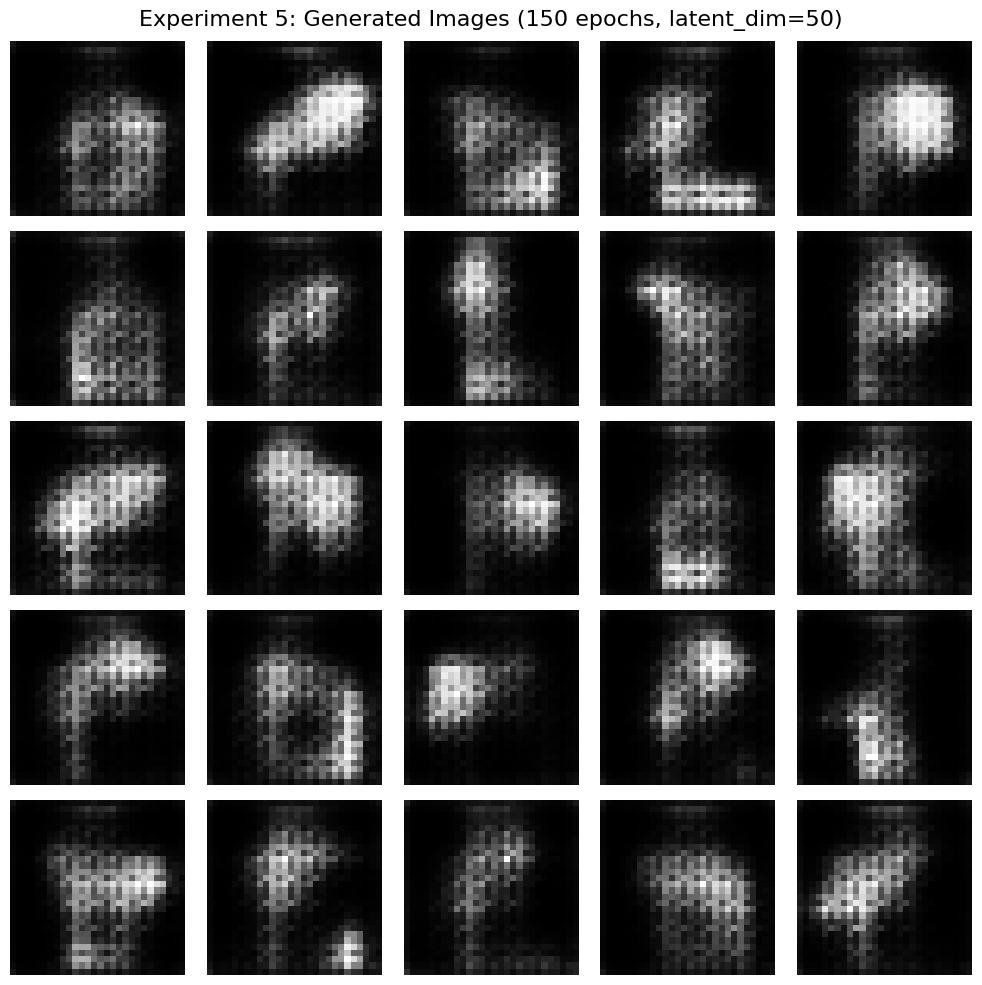


Experiment 5 completed!

EXPERIMENT 6: Epochs=150, Latent Dim=100

Training GAN: Epochs=150, Latent Dim=100
Epoch 0/150 | D Loss: 0.7046, D Acc: 26.56% | G Loss: 0.6905
Epoch 10/150 | D Loss: 0.4010, D Acc: 50.00% | G Loss: 0.1563
Epoch 20/150 | D Loss: 0.2606, D Acc: 100.00% | G Loss: 0.3567
Epoch 30/150 | D Loss: 0.1766, D Acc: 98.44% | G Loss: 0.0033
Epoch 40/150 | D Loss: 0.4605, D Acc: 67.97% | G Loss: 0.0316
Epoch 50/150 | D Loss: 0.5321, D Acc: 50.39% | G Loss: 0.1820
Epoch 60/150 | D Loss: 0.2914, D Acc: 92.19% | G Loss: 2.1266
Epoch 70/150 | D Loss: 0.5336, D Acc: 62.89% | G Loss: 0.6141
Epoch 80/150 | D Loss: 0.5524, D Acc: 72.66% | G Loss: 0.6669
Epoch 90/150 | D Loss: 0.5738, D Acc: 70.31% | G Loss: 0.4909
Epoch 100/150 | D Loss: 0.6170, D Acc: 67.97% | G Loss: 0.8072
Epoch 110/150 | D Loss: 0.5307, D Acc: 75.39% | G Loss: 0.8408
Epoch 120/150 | D Loss: 0.5859, D Acc: 70.70% | G Loss: 0.4120
Epoch 130/150 | D Loss: 0.5995, D Acc: 66.02% | G Loss: 0.1836
Epoch 140/150 | D L

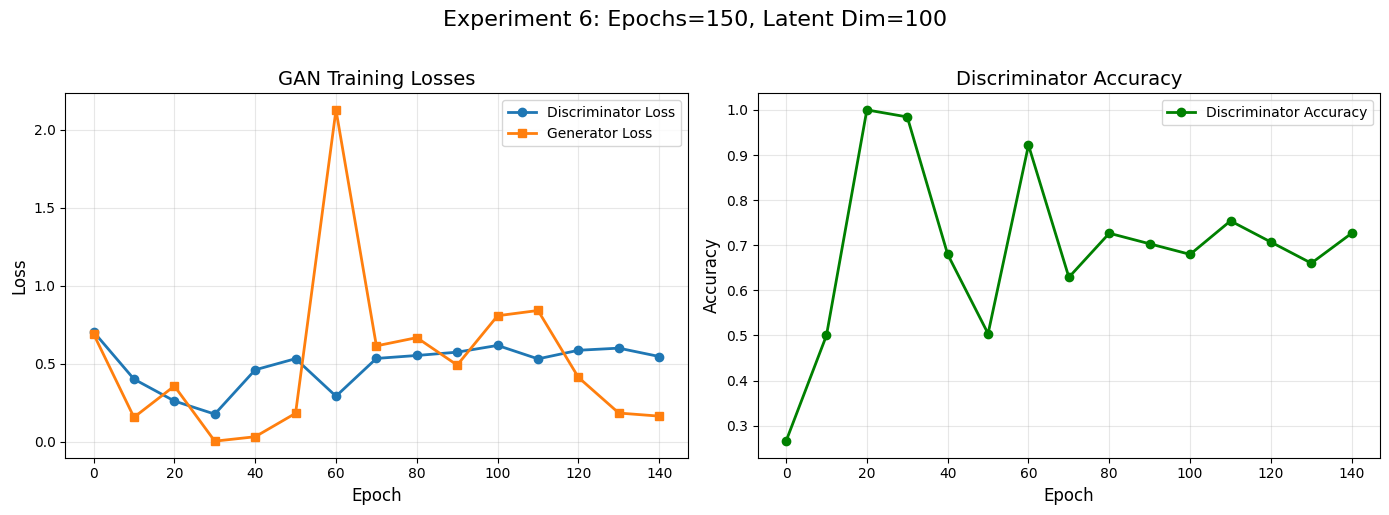

Saved: exp6_150epochs_100dim.png


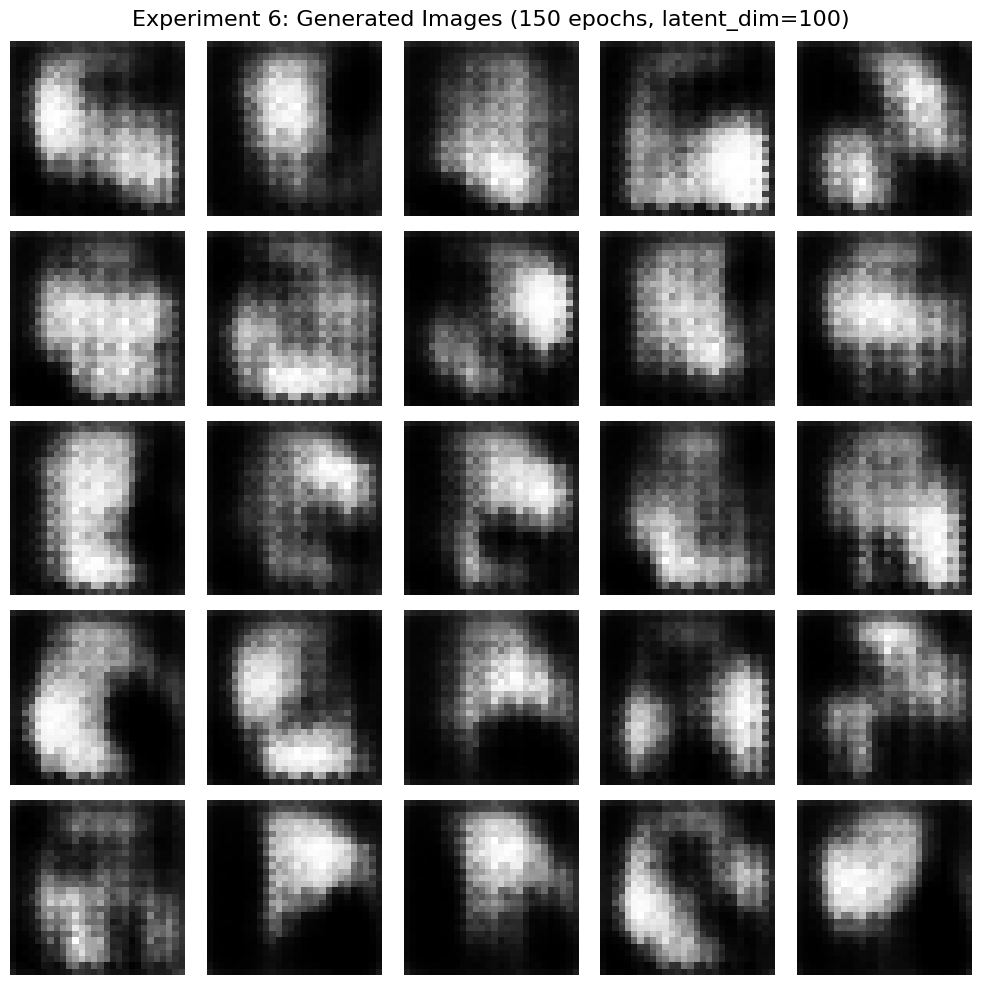


Experiment 6 completed!

EXPERIMENT 7: Epochs=200, Latent Dim=20

Training GAN: Epochs=200, Latent Dim=20
Epoch 0/200 | D Loss: 0.6782, D Acc: 39.06% | G Loss: 0.6238
Epoch 10/200 | D Loss: 0.3820, D Acc: 50.00% | G Loss: 0.0586
Epoch 20/200 | D Loss: 0.3391, D Acc: 100.00% | G Loss: 0.0265
Epoch 30/200 | D Loss: 0.3047, D Acc: 100.00% | G Loss: 0.0776
Epoch 40/200 | D Loss: 0.2496, D Acc: 98.44% | G Loss: 0.0088
Epoch 50/200 | D Loss: 0.1499, D Acc: 100.00% | G Loss: 0.0282
Epoch 60/200 | D Loss: 0.0696, D Acc: 99.61% | G Loss: 0.0056
Epoch 70/200 | D Loss: 0.0306, D Acc: 100.00% | G Loss: 0.0032
Epoch 80/200 | D Loss: 0.0478, D Acc: 99.22% | G Loss: 0.0011
Epoch 90/200 | D Loss: 0.0380, D Acc: 98.83% | G Loss: 0.0003
Epoch 100/200 | D Loss: 0.5086, D Acc: 85.94% | G Loss: 0.0003
Epoch 110/200 | D Loss: 0.0219, D Acc: 99.61% | G Loss: 0.0029
Epoch 120/200 | D Loss: 0.0160, D Acc: 99.22% | G Loss: 0.0010
Epoch 130/200 | D Loss: 0.0095, D Acc: 100.00% | G Loss: 0.0005
Epoch 140/200 | D

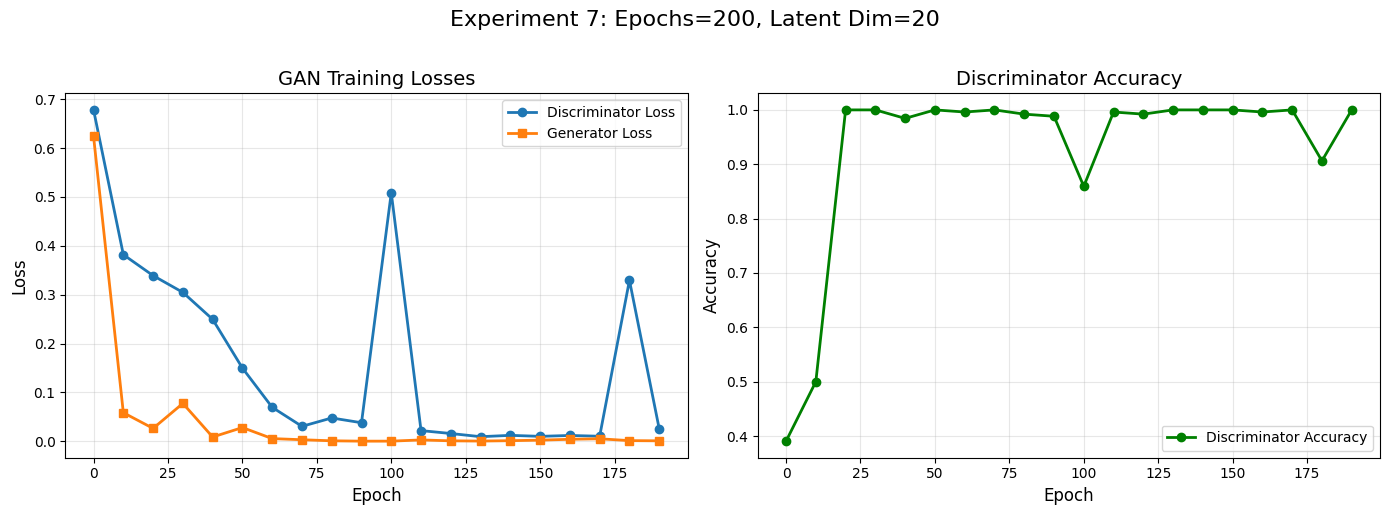

Saved: exp7_200epochs_20dim.png


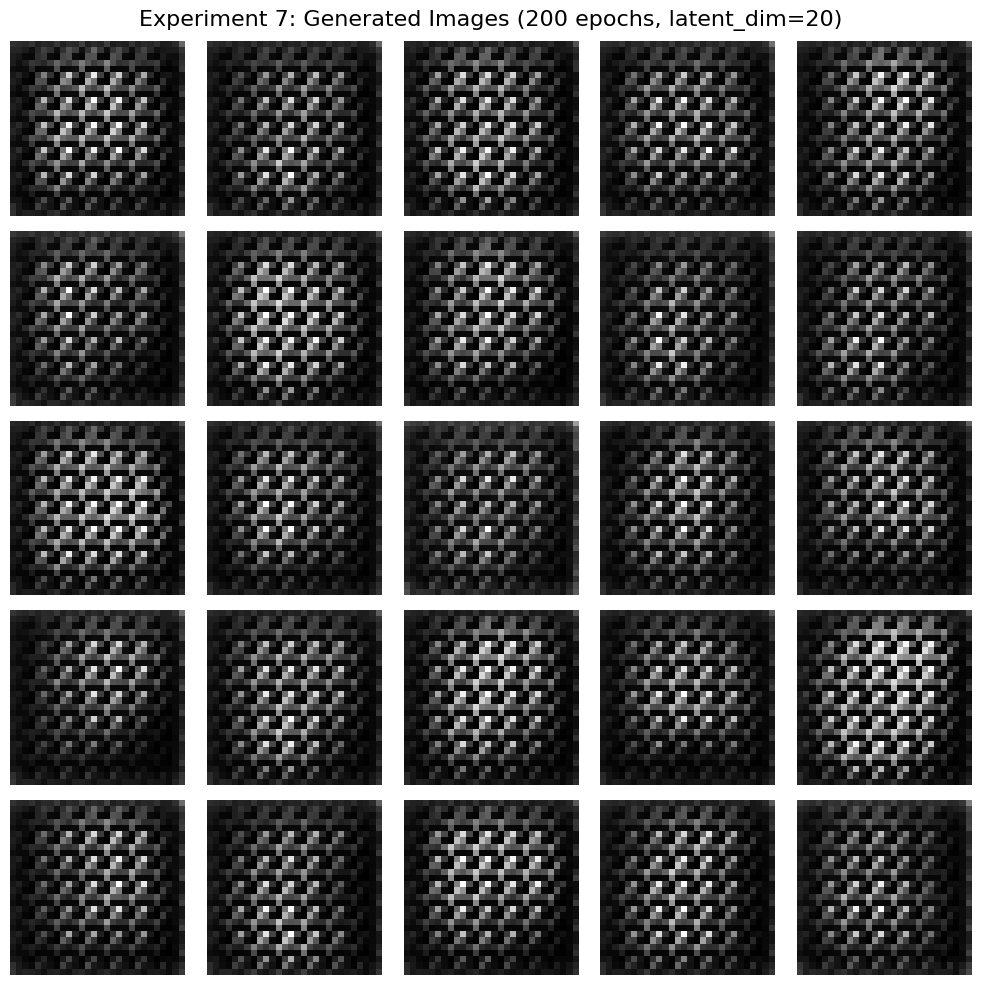


Experiment 7 completed!

EXPERIMENT 8: Epochs=200, Latent Dim=50

Training GAN: Epochs=200, Latent Dim=50
Epoch 0/200 | D Loss: 0.6788, D Acc: 41.80% | G Loss: 0.6312
Epoch 10/200 | D Loss: 0.3892, D Acc: 50.00% | G Loss: 0.1128
Epoch 20/200 | D Loss: 0.3558, D Acc: 73.05% | G Loss: 0.1329
Epoch 30/200 | D Loss: 0.3369, D Acc: 93.75% | G Loss: 0.0400
Epoch 40/200 | D Loss: 0.2573, D Acc: 100.00% | G Loss: 0.2211
Epoch 50/200 | D Loss: 0.3959, D Acc: 89.45% | G Loss: 0.9555
Epoch 60/200 | D Loss: 0.0972, D Acc: 100.00% | G Loss: 2.1256
Epoch 70/200 | D Loss: 0.1606, D Acc: 99.61% | G Loss: 1.2294
Epoch 80/200 | D Loss: 0.7764, D Acc: 38.67% | G Loss: 0.3035
Epoch 90/200 | D Loss: 0.6725, D Acc: 58.59% | G Loss: 0.6245
Epoch 100/200 | D Loss: 0.6875, D Acc: 54.30% | G Loss: 0.7851
Epoch 110/200 | D Loss: 0.6548, D Acc: 62.89% | G Loss: 0.8010
Epoch 120/200 | D Loss: 0.6391, D Acc: 63.28% | G Loss: 0.8465
Epoch 130/200 | D Loss: 0.5855, D Acc: 71.88% | G Loss: 0.7949
Epoch 140/200 | D Lo

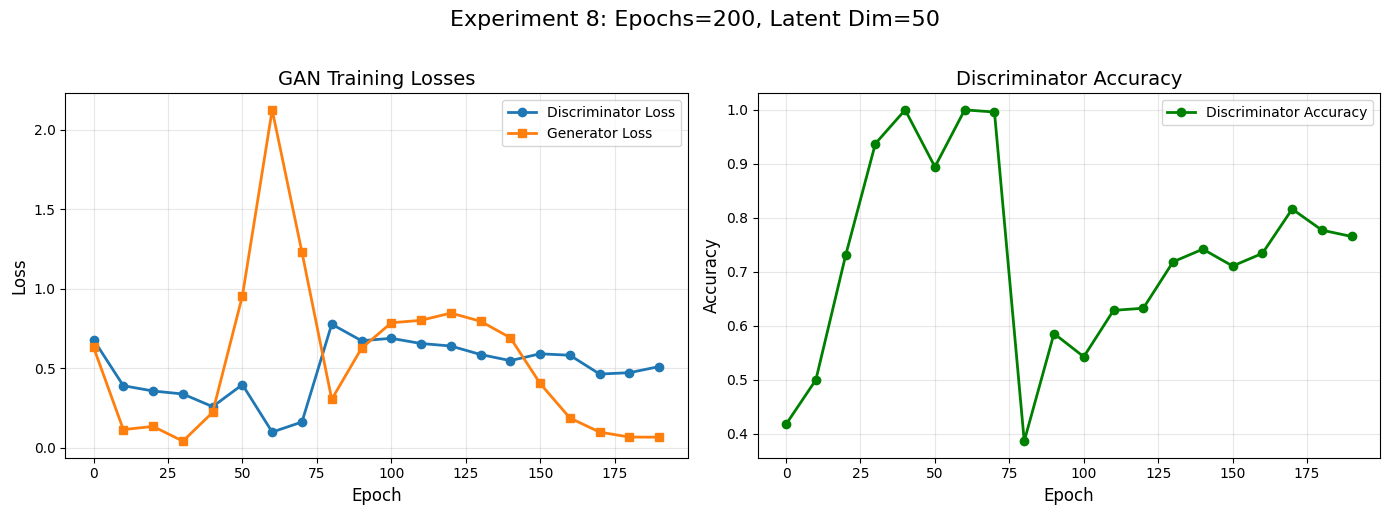

Saved: exp8_200epochs_50dim.png


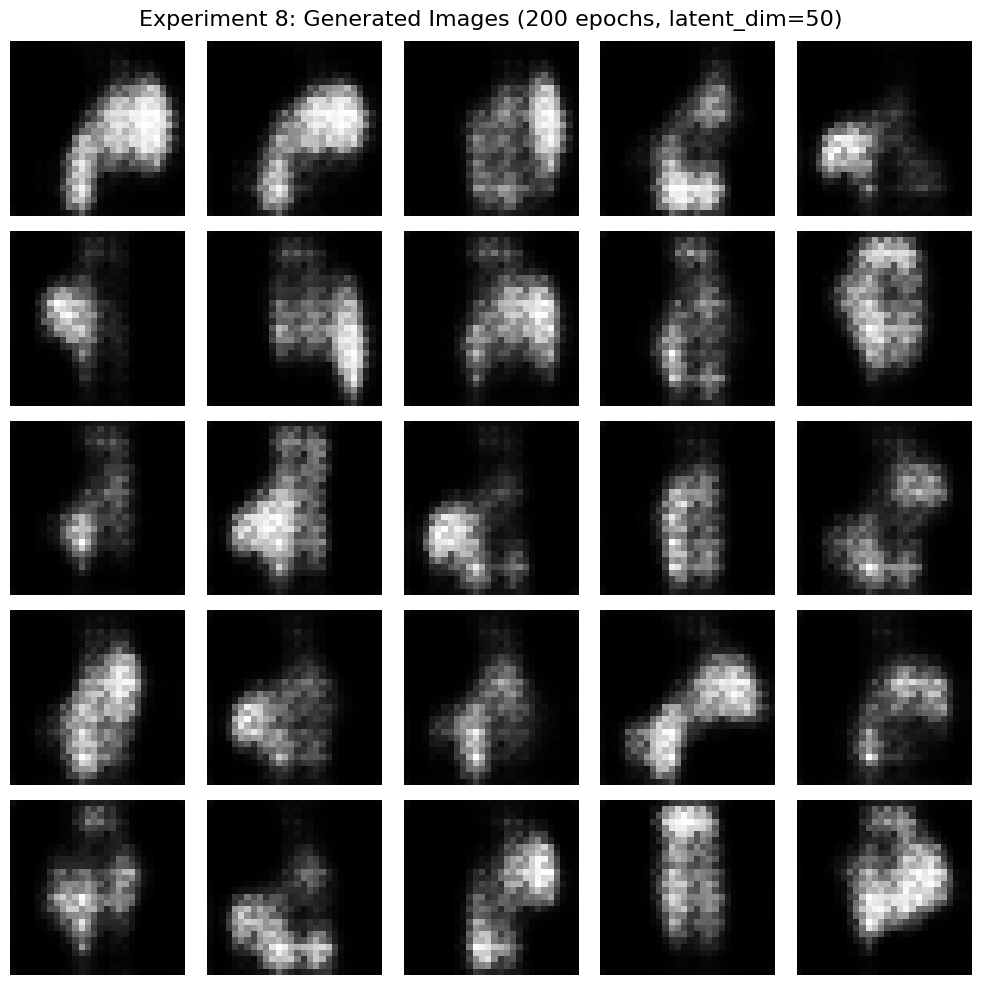


Experiment 8 completed!

EXPERIMENT 9: Epochs=200, Latent Dim=100

Training GAN: Epochs=200, Latent Dim=100
Epoch 0/200 | D Loss: 0.6873, D Acc: 30.47% | G Loss: 0.5986
Epoch 10/200 | D Loss: 0.4002, D Acc: 50.00% | G Loss: 0.0599
Epoch 20/200 | D Loss: 0.3909, D Acc: 50.00% | G Loss: 0.1212
Epoch 30/200 | D Loss: 0.3425, D Acc: 95.70% | G Loss: 0.0267
Epoch 40/200 | D Loss: 0.3614, D Acc: 82.03% | G Loss: 0.1107
Epoch 50/200 | D Loss: 0.2062, D Acc: 100.00% | G Loss: 1.5603
Epoch 60/200 | D Loss: 0.9377, D Acc: 50.00% | G Loss: 1.5115
Epoch 70/200 | D Loss: 0.1671, D Acc: 99.22% | G Loss: 0.5836
Epoch 80/200 | D Loss: 0.2845, D Acc: 92.19% | G Loss: 2.1094
Epoch 90/200 | D Loss: 0.1619, D Acc: 98.44% | G Loss: 2.8963
Epoch 100/200 | D Loss: 1.1900, D Acc: 7.03% | G Loss: 0.7209
Epoch 110/200 | D Loss: 0.5956, D Acc: 73.05% | G Loss: 1.2274
Epoch 120/200 | D Loss: 0.5304, D Acc: 84.38% | G Loss: 1.1827
Epoch 130/200 | D Loss: 0.5765, D Acc: 74.22% | G Loss: 1.1124
Epoch 140/200 | D Lo

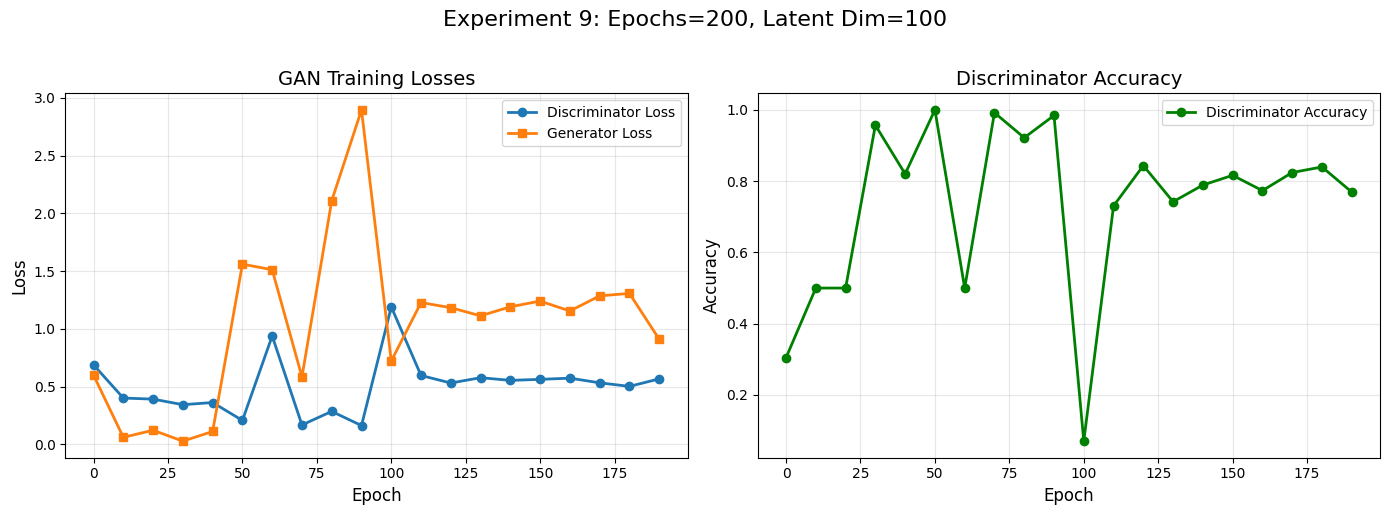

Saved: exp9_200epochs_100dim.png


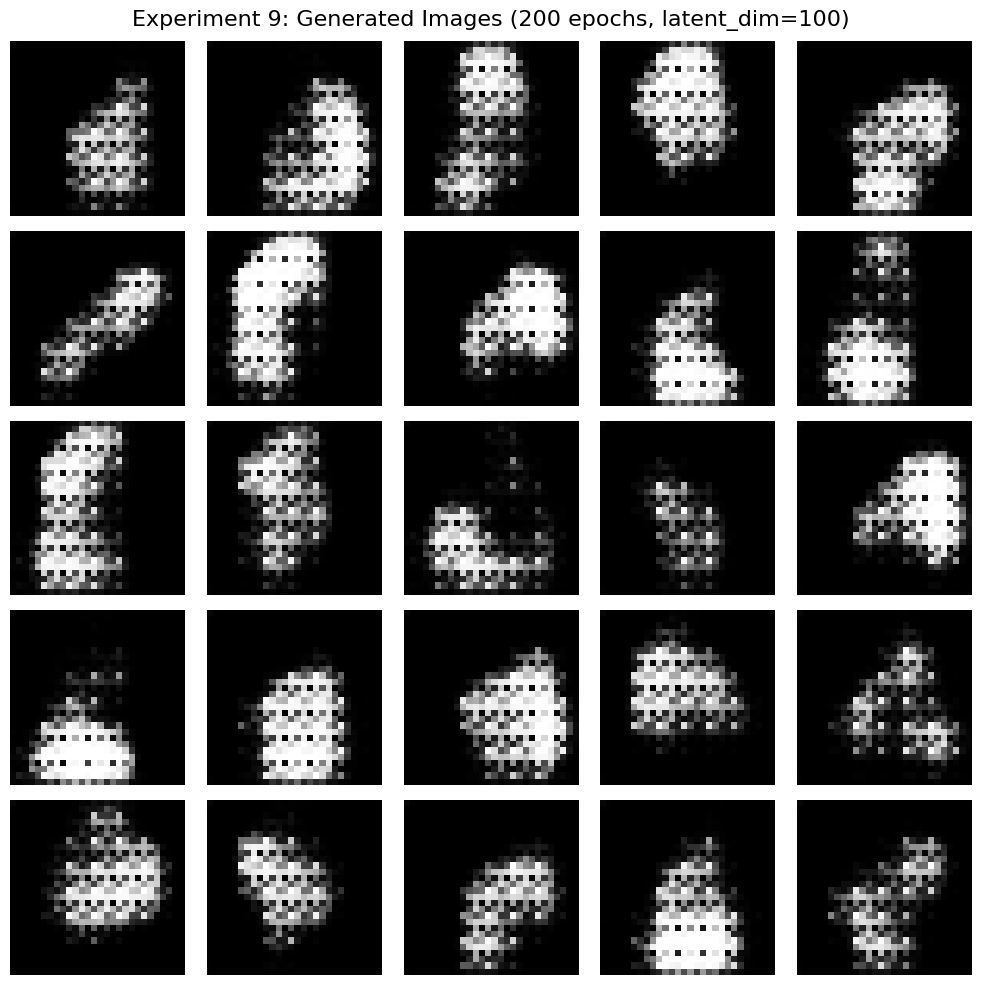


Experiment 9 completed!

ALL EXPERIMENTS COMPLETED!


In [14]:
epoch_list = [100, 150, 200]
latent_dim_list = [20, 50, 100]

print("Starting all experiments...")
print(f"Total experiments: {len(epoch_list) * len(latent_dim_list)}")

all_results = run_all_experiments(
    epoch_list=epoch_list,
    latent_dim_list=latent_dim_list,
    batch_size=128,
    save_interval=10
)

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETED!")
print("="*70)

COMPARISON OF ALL EXPERIMENTS


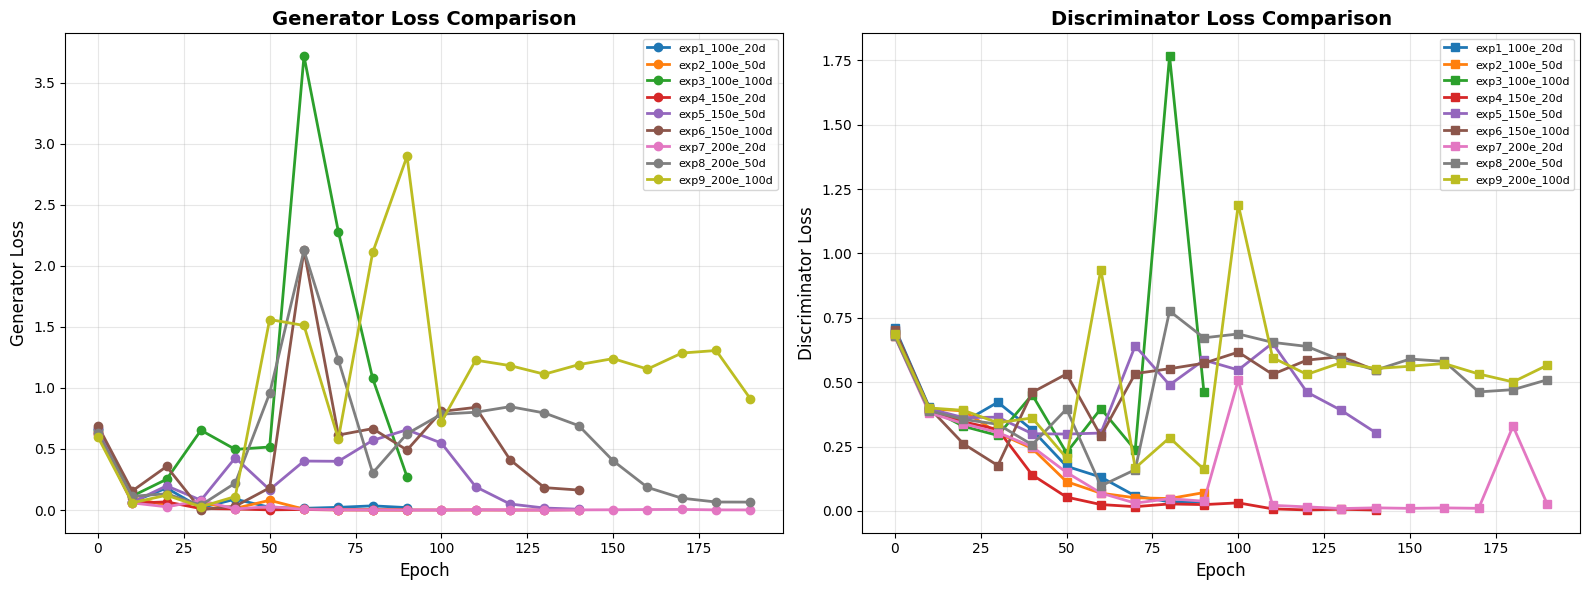


Comparison plot saved!


In [15]:
print("="*70)
print("COMPARISON OF ALL EXPERIMENTS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for exp_name, history in all_results['histories'].items():
    axes[0].plot(history['epochs'], history['g_loss'], marker='o', 
                label=exp_name, linewidth=2)

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Generator Loss', fontsize=12)
axes[0].set_title('Generator Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=8, loc='best')
axes[0].grid(True, alpha=0.3)

for exp_name, history in all_results['histories'].items():
    axes[1].plot(history['epochs'], history['d_loss'], marker='s', 
                label=exp_name, linewidth=2)

axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Discriminator Loss', fontsize=12)
axes[1].set_title('Discriminator Loss Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=8, loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('all_experiments_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nComparison plot saved!")

In [16]:
print("\n" + "="*70)
print("EXPERIMENTS SUMMARY TABLE")
print("="*70)

print(f"\n{'Experiment':<15} {'Epochs':<10} {'Latent Dim':<15} {'Final G Loss':<15} {'Final D Loss':<15}")
print("-" * 70)

for exp_name, history in all_results['histories'].items():
    final_g_loss = history['g_loss'][-1]
    final_d_loss = history['d_loss'][-1]

    parts = exp_name.split('_')
    epochs = parts[1].replace('e', '')
    latent_dim = parts[2].replace('d', '')
    
    print(f"{exp_name:<15} {epochs:<10} {latent_dim:<15} {final_g_loss:<15.4f} {final_d_loss:<15.4f}")


EXPERIMENTS SUMMARY TABLE

Experiment      Epochs     Latent Dim      Final G Loss    Final D Loss   
----------------------------------------------------------------------
exp1_100e_20d   100        20              0.0200          0.0357         
exp2_100e_50d   100        50              0.0014          0.0714         
exp3_100e_100d  100        100             0.2722          0.4626         
exp4_150e_20d   150        20              0.0021          0.0038         
exp5_150e_50d   150        50              0.0069          0.3045         
exp6_150e_100d  150        100             0.1638          0.5460         
exp7_200e_20d   200        20              0.0010          0.0256         
exp8_200e_50d   200        50              0.0651          0.5097         
exp9_200e_100d  200        100             0.9094          0.5663         


In [17]:
print("\n" + "="*70)
print("GENERATING NEW DATASET")
print("="*70)

best_exp_key = 'exp8_200e_50d'
best_generator = all_results['generators'][best_exp_key]
best_latent_dim = 50

n_images = 10000
batch_size = 100
generated_dataset = []

print(f"Generating {n_images} new images using {best_exp_key}...")

for i in range(0, n_images, batch_size):
    noise = np.random.normal(0, 1, (batch_size, best_latent_dim))
    batch_images = best_generator.predict(noise, verbose=0)
    generated_dataset.append(batch_images)
    
    if (i + batch_size) % 1000 == 0:
        print(f"Generated {i + batch_size}/{n_images} images...")

generated_dataset = np.vstack(generated_dataset)
print(f"Generated dataset shape: {generated_dataset.shape}")

generated_dataset_uint8 = ((generated_dataset + 1) * 127.5).astype(np.uint8)

np.save('generated_fashion_mnist_dataset.npy', generated_dataset_uint8)
print("Saved: generated_fashion_mnist_dataset.npy")


GENERATING NEW DATASET
Generating 10000 new images using exp8_200e_50d...
Generated 1000/10000 images...
Generated 2000/10000 images...
Generated 3000/10000 images...
Generated 4000/10000 images...
Generated 5000/10000 images...
Generated 6000/10000 images...
Generated 7000/10000 images...
Generated 8000/10000 images...
Generated 9000/10000 images...
Generated 10000/10000 images...
Generated dataset shape: (10000, 28, 28, 1)
Saved: generated_fashion_mnist_dataset.npy


SAMPLE FROM GENERATED DATASET


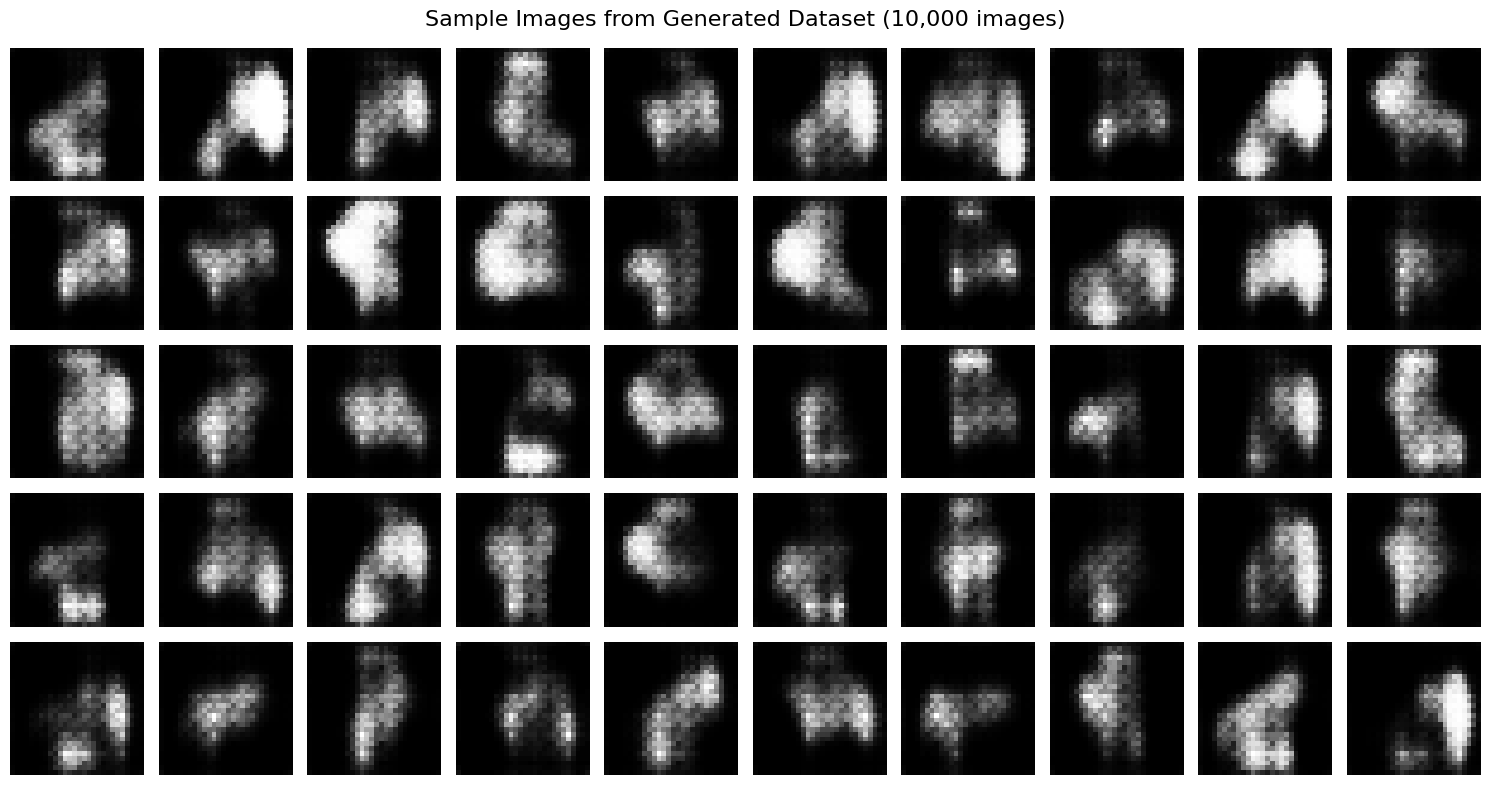

In [18]:
print("="*70)
print("SAMPLE FROM GENERATED DATASET")
print("="*70)

fig, axes = plt.subplots(5, 10, figsize=(15, 8))
random_indices = np.random.choice(len(generated_dataset_uint8), 50, replace=False)

for i, ax in enumerate(axes.flat):
    img = generated_dataset_uint8[random_indices[i]].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.suptitle('Sample Images from Generated Dataset (10,000 images)', fontsize=16)
plt.tight_layout()
plt.savefig('generated_dataset_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
print("="*70)
print("SAVING MODELS")
print("="*70)

os.makedirs('gan_models', exist_ok=True)

for exp_name, generator in all_results['generators'].items():
    filename = f'gan_models/{exp_name}_generator.h5'
    generator.save(filename)
    print(f"Saved: {filename}")

print("\nAll models saved successfully!")

SAVING MODELS
Saved: gan_models/exp1_100e_20d_generator.h5
Saved: gan_models/exp2_100e_50d_generator.h5
Saved: gan_models/exp3_100e_100d_generator.h5
Saved: gan_models/exp4_150e_20d_generator.h5
Saved: gan_models/exp5_150e_50d_generator.h5
Saved: gan_models/exp6_150e_100d_generator.h5
Saved: gan_models/exp7_200e_20d_generator.h5
Saved: gan_models/exp8_200e_50d_generator.h5
Saved: gan_models/exp9_200e_100d_generator.h5

All models saved successfully!


/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
print("="*70)
print("LOADING AND VERIFYING GENERATED DATASET")
print("="*70)

loaded_dataset = np.load('generated_fashion_mnist_dataset.npy')
print(f"Loaded dataset shape: {loaded_dataset.shape}")
print(f"Data type: {loaded_dataset.dtype}")
print(f"Value range: [{loaded_dataset.min()}, {loaded_dataset.max()}]")

print("\nDataset ready for use in:")
print("✓ Training classifiers")
print("✓ Data augmentation")
print("✓ Transfer learning")
print("✓ Research experiments")

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
print("="*70)

LOADING AND VERIFYING GENERATED DATASET
Loaded dataset shape: (10000, 28, 28, 1)
Data type: uint8
Value range: [0, 255]

Dataset ready for use in:
✓ Training classifiers
✓ Data augmentation
✓ Transfer learning
✓ Research experiments

ALL EXPERIMENTS COMPLETED SUCCESSFULLY!
